# <center> Homework 7: Support Vector Machines </center>
<center> Anushna Prakash </center>
<center> May 28, 2021 </center>

$$ \min_{\alpha \in \mathbb{R}^n} F(\alpha):= \frac{1}{n} \sum_{i=1}^{n} \ell(y_i, (K\alpha)_i) + \lambda \alpha^T K \alpha$$  
$$ \min_{\alpha \in \mathbb{R}^n} F(\alpha):= \frac{1}{n} \sum_{i=1}^{n} (\max \{0, 1 - y_i (K\alpha)_i\})^2 + \lambda \alpha^T K \alpha$$  
$$ \nabla F(\alpha) = -\frac{2}{n} \sum_{i=1}^{n} K_i y_i  \max \{0, 1-y_i K_i^T \alpha\} + 2\lambda K \alpha $$  
$$
    \nabla F(\alpha) = 
    \begin{cases}
        -\frac{2}{n} \sum_{i=1}^{n} K_i y_i (1 - y_i K_i^T \alpha) + 2 \lambda K \alpha, & \text{for } 1-y_i(K\alpha)_i > 0\\
        2 \lambda K \alpha, & \text{for } 1-y_i(K\alpha)_i <= 0\\
    \end{cases}
$$

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [53]:
def kernal(x, y, b, p):
    return ((x @ y.T) + b)**p

In [54]:
def computegram(k, x, b, p):
#     n = x.shape[0]
#     K = np.empty(shape = (n, n))
    
    K = k(x, x, b, p)
    return K

In [55]:
def kernaleval(k, x, x_star, b, p):
    kernal_evals = k(x, x_star, b, p)
    
    return kernal_evals

In [56]:
def svm_f(alpha, gram, X, y, lambda_):
    n = X.shape[0]
    K_a = np.dot(gram, alpha)
#     loss = 0
#     for i in range(n):
#         cond = 1.0 - y[i] * K_a[i]
#         if cond > 0:
#             loss += np.square(cond)
    loss = 1.0 - np.multiply(y, K_a)
    loss_condition = np.where(loss > 0, loss, 0)

    return np.mean(np.square(loss_condition)) + lambda_ * (alpha.T @ gram @ alpha)

In [57]:
def svm_grad(alpha, gram, X, y, lambda_):
    n = len(X)
    K_a = np.dot(gram, alpha)
    loss_condition = 1.0 - np.multiply(y, np.dot(gram, alpha))
    reg = 2.0 * lambda_ * K_a
    loss_delta = -2 * y * gram
    loss = np.where(loss_condition > 0, loss_condition, 0)
    loss_grad = loss_delta * loss
    
#     for i in range(n):
#         if loss[i] > 0:
#             K_y = gram[i] * y[i]
#             loss_grad += -2 * K_y * loss[i]
        
    return (1/n) * np.sum(loss_grad, axis = 1) + reg

In [58]:
def backtracking(eta_init, decay_rate, prop_constant, alpha, *args):
    eta = eta_init
    
    def decrease_condition(eta):
        grad = svm_grad(alpha, *args)
        left = svm_f(alpha - eta * grad, *args) - svm_f(alpha, *args)
        right = -eta * prop_constant * np.linalg.norm(grad)**2
        return left <= right
    
    while not decrease_condition(eta):
        eta *= decay_rate
    
    return eta

In [59]:
def mysvm(eta_init, tol, alpha_init, *args):
    theta = alpha_init.copy()
    alpha = alpha_init.copy()
    iters = [alpha]
    grad = svm_grad(alpha, *args)
    decay_rate = 0.3
    prop_constant = 0.3
    t = 0
    
    while np.linalg.norm(grad) > tol:
#         print(grad)
        eta = backtracking(eta_init, decay_rate, prop_constant, theta, *args)
        alpha_t = theta - eta * svm_grad(theta, *args)
        theta = alpha_t + (t/(t + 3)) * (alpha_t - alpha)
        grad = svm_grad(alpha_t, *args)
        iters.append(alpha_t)
        alpha = alpha_t
        t += 1
    
    return iters

In [60]:
# Download the data
digits = load_digits().data
y = load_digits().target

# Normalize and split 80/20 training and test
digits = normalize(digits, norm = 'l2', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(digits, y, train_size = 0.8, random_state = 12345)

In [61]:
digits = np.unique(y)
classifiers = {}

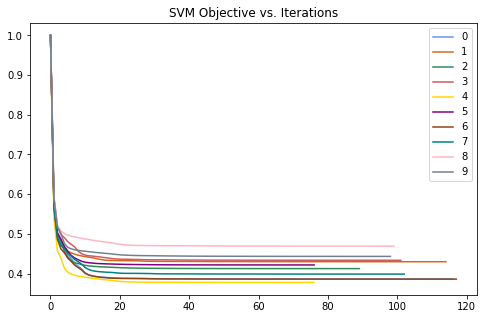

In [62]:
eta_init = 0.000001
tol = 1.0
alpha_init = np.zeros(X_train.shape[0])
lam = 10.0
B = 1
P = 7
K = computegram(kernal, X_train, B, P)

plt.figure(figsize = (8, 5))
for d in digits:
    # train a classifier on y_i^d = 1 if y_i = d, -1 else
    colors = {0: 'cornflowerblue', 1: 'chocolate', 2: 'seagreen', 3: 'indianred', 4: 'gold',
              5: 'purple', 6: 'saddlebrown', 7: 'teal', 8: 'lightpink', 9: 'slategrey'}
    y_train_d = np.where(y_train == d, 1, -1)
    svm_d = mysvm(eta_init, tol, alpha_init, K, X_train, y_train_d, lam)
    classifiers[d] = svm_d[-1]
    obj = [svm_f(a, K, X_train, y_train_d, lam) for a in svm_d]
    plt.plot(obj, c = colors[d])

plt.title('SVM Objective vs. Iterations')
plt.legend(labels = digits)

In [32]:
def accuracy(truth, preds):
    return np.mean(truth == preds)

def preds_kernal(alpha, x, x_star, *args):
    preds = alpha @ kernaleval(kernal, x, x_star, *args)
    
    return np.where(preds > 0, 1, -1)

In [33]:
y_0 = np.where(y_test == 0, 1, -1)
preds = preds_kernal(classifiers[0], X_train, X_test, B, P)
accuracy(y_0, preds)

0.9138888888888889

In [63]:
def get_fold_indices(n, K, j):
    fold_size = n // K
    
    idx = np.arange(n)
    val_idx = idx[j * fold_size : (j+1) * fold_size]
    
    if j == 0: 
        train_idx = idx[fold_size : n]
    elif j == K-1:
        train_idx = idx[0 : (K-1) * fold_size]
    else:
        first_range = idx[0 : j * fold_size]
        second_range = idx[(j+1) * fold_size : n]
        train_idx = np.concatenate((first_range, second_range))
    
    return train_idx, val_idx

def K_fold_cross_validation(folds, digit, lambdas, X, y):
    
    n = len(X)
    best_lambda = None
    best_performance = 0.0
    y_d = np.where(y == digit, 1, -1)
    eta_init = 1e-6
    tol = 1.0
    B = 1
    P = 7
        
    for i, lam in enumerate(lambdas):
        
        print("---------------------------------------------------")
        print("Evaluating lambda =", lam, end="")
        
        accuracies = np.zeros(folds)
        for j in range(folds):
            
            print(".", end="")
            
            # Subset into training and validation set.
            train_idx, val_idx = get_fold_indices(n, folds, j)
            X_train, y_train = X[train_idx], y_d[train_idx]
            X_val, y_val = X[val_idx], y_d[val_idx]
            
            # Train on the training set.
            gram = computegram(kernal, X_train, B, P)
            a_init = np.zeros(X_train.shape[0])
            alpha = mysvm(eta_init, tol, a_init, gram, X_train, y_train, lam)[-1]
            
            # Evaluate on the validation set.
            
            val_preds = preds_kernal(alpha, X_train, X_val, B, P)
            accuracies[j] = accuracy(y_val, val_preds)
        
        performance = np.mean(accuracies)
        print("")
        print("Average Accuracy:", performance)
        print("---------------------------------------------------")
        
        if performance > best_performance:
            best_performance = performance
            best_lambda = lam
            
    return best_lambda, best_performance

In [65]:
# Run on digit = 8
lambdas = np.logspace(-3, 3, 5)
K_fold_cross_validation(5, 8, lambdas, X_train, y_train)

---------------------------------------------------
Evaluating lambda = 0.001.....
Average Accuracy: 0.9790940766550522
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 0.03162277660168379.....
Average Accuracy: 0.9763066202090593
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 1.0.....
Average Accuracy: 0.937979094076655
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 31.622776601683793.....
Average Accuracy: 0.90801393728223
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 1000.0.....
Average Accuracy: 0.90801393728223
---------------------------------------------------


(0.001, 0.9790940766550522)

In [67]:
# Run 5-fold CV on all digit classifiers
lambdas = np.logspace(-2, 2, 5)
cv_lams = {}

for d in digits:
    best_lam, best_acc = K_fold_cross_validation(5, d, lambdas, X_train, y_train)
    cv_lams[d] = best_lam
    print("Digit ", d, " has optimal accuracy with lambda = ", best_lam, ". Accuracy = ", best_acc)

---------------------------------------------------
Evaluating lambda = 0.01.....
Average Accuracy: 0.9986062717770036
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 0.1.....
Average Accuracy: 0.9986062717770036
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 1.0.....
Average Accuracy: 0.9979094076655052
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 10.0.....
Average Accuracy: 0.9073170731707318
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 100.0.....
Average Accuracy: 0.9017421602787457
---------------------------------------------------
Digit  0  has optimal accuracy with lambda =  0.01 . Accuracy =  0.9986062717770036
---------------------------------------------------
Evaluating

Evaluating lambda = 100.0.....
Average Accuracy: 0.90801393728223
---------------------------------------------------
Digit  8  has optimal accuracy with lambda =  0.1 . Accuracy =  0.9770034843205575
---------------------------------------------------
Evaluating lambda = 0.01.....
Average Accuracy: 0.9916376306620208
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 0.1.....
Average Accuracy: 0.992334494773519
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 1.0.....
Average Accuracy: 0.9616724738675959
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 10.0.....
Average Accuracy: 0.8961672473867595
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 100.0.....
Average Accuracy: 0.896167247386759

In [78]:
print(pd.DataFrame.from_dict(cv_lams, orient = 'index', columns = ['Optimal Lambda']))

   Optimal Lambda
0            0.01
1            0.10
2            0.10
3            0.01
4            0.10
5            0.01
6            0.10
7            0.10
8            0.10
9            0.10


In [ ]:
eta_init = 0.000001
tol = 1.0
alpha_init = np.zeros(X_train.shape[0])
B = 1
P = 7
K = computegram(kernal, X_train, B, P)

for d in digits:
    y_train_d = np.where(y_train == d, 1, -1)
    svm_d = mysvm(eta_init, tol, alpha_init, K, X_train, y_train_d, cv_lams[d])
    classifiers[d] = svm_d[-1]